# Test notebook for Pastas with PEST++ GLM and PEST HP Solver

## Packages

In [1]:
from pathlib import Path

import pandas as pd
import pastas as ps

import pastas_plugins.pest as psp
from pyemu.utils import get_pestpp

get_pestpp(bindir="bin", subset=["pestpp-glm"])

/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/pyemu/__init__.py:37: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'
/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Fetched release '5.2.16' info from 'usgs/pestpp'.

['pestpp-glm']

A *.tar.gz file ('/tmp/tmp1hupsjoa/pestpp-5.2.16-linux.tar.gz') has been downloaded  and will be converted to a zip file ('/tmp/tmp1hupsjoa/pestpp-5.2.16-linux.zip').

Extracting 1 file to '/home/vonkm/repos/pastas-plugins/docs/examples/bin'
pestpp-glm

Updated pyemu metadata file: '/home/vonkm/.local/share/pyemu/get_pestpp.json'


## Load Data

In [ ]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [ ]:
ml = ps.Model(head, name="PestGLM")
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)
ml.add_stressmodel(sm)

### Solve with Pest GLM

In [ ]:
solver = psp.PestGlmSolver(
    exe_name="bin/pestpp-glm",
    model_ws=Path("pestf_glm/model"),
    temp_ws=Path("pestf_glm/temp"),
    noptmax=100,
)
ml.solve(solver=solver, report=False)

2025-12-24 10:38:14.971547 starting: opening PstFrom.log for logging
2025-12-24 10:38:14.971956 starting PstFrom process
2025-12-24 10:38:14.971994 starting: setting up dirs
2025-12-24 10:38:14.972056 starting: removing existing new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_glm/temp'
2025-12-24 10:38:14.989949 finished: removing existing new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.017893
2025-12-24 10:38:14.990052 starting: copying original_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_glm/temp'
2025-12-24 10:38:14.990780 finished: copying original_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.000728
2025-12-24 10:38:14.992220 finished: setting up dirs took: 0:00:00.020226
2025-12-24 10:38:15.004959 starting: adding grid type d style parameters

/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/pyemu/logger.py:100: PyemuWarning: 2025-12-24 10:38:15.027117 WARNING: add_py_function() command: run() is not being called directly



12/24 10:38:16 remaining file transfers: 0                                       

   4 runs complete :  0 runs failed
   0.00132 avg run time (min) : 0.0261 run mgr time (min)
   1 agents connected


  computing upgrade vectors... 
  computing upgrade vector (lambda = 1e-10)  1 / 7             
  computing upgrade vector (lambda = 1e-08)  2 / 7             
  computing upgrade vector (lambda = 1e-07)  3 / 7             
  computing upgrade vector (lambda = 1e-06)  4 / 7             
  computing upgrade vector (lambda = 1e-05)  5 / 7             
  computing upgrade vector (lambda = 0.0001)  6 / 7             
  computing upgrade vector (lambda = 0.01)  7 / 7             
-->starting iteration FOSM process...
-->finished iteration FOSM process...

  performing upgrade vector model runs...     running model 14 times
    starting at 12/24/25 10:38:16
    1 agents ready


PANTHER progress
   avg = average model run time in minutes
   runs(C = completed | F = failed | T = timed out)
   age

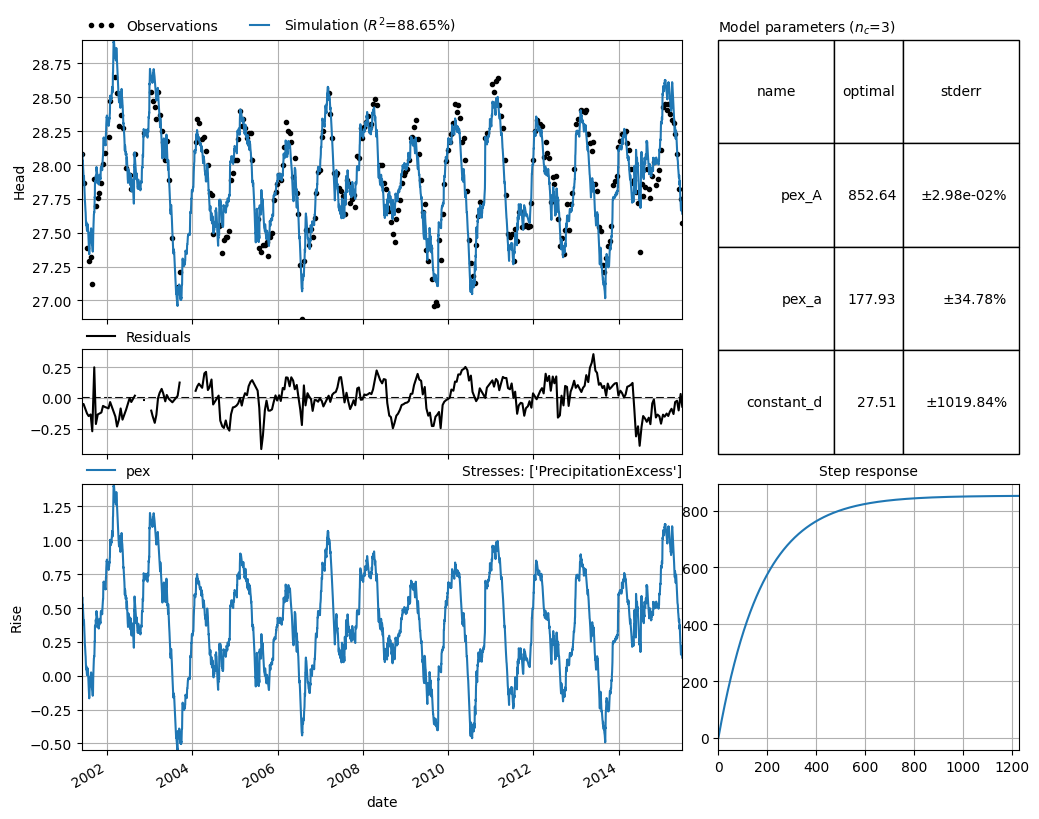

In [5]:
_ = ml.plots.results(stderr=True)

### Solve with Pest HP

In [ ]:
ml_hp = ml.copy()
ml_hp.name = "PestHp"
control_data = dict(
    phiredstp=1e-3,
    nphistp=10,
    nphinored=10,
    relparstp=1e-3,
)

solver = psp.PestHpSolver(
    exe_name="bin/pest_hp",
    exe_agent="bin/agent_hp",
    model_ws=Path("pestf_hp/model"),
    temp_ws=Path("pestf_hp/temp"),
    noptmax=30,
    control_data=control_data,
)
ml_hp.add_solver(solver)
ml_hp.solve(solver=solver, report=False)

2025-12-24 10:39:31.730079 starting: opening PstFrom.log for logging
2025-12-24 10:39:31.731088 starting PstFrom process
2025-12-24 10:39:31.731149 starting: setting up dirs
2025-12-24 10:39:31.731233 starting: removing existing new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_hp/temp'
2025-12-24 10:39:31.733051 finished: removing existing new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_hp/temp' took: 0:00:00.001818
2025-12-24 10:39:31.733209 starting: copying original_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_hp/model' to new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_hp/temp'
2025-12-24 10:39:31.733719 finished: copying original_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_hp/model' to new_d '/home/vonkm/repos/pastas-plugins/docs/examples/pestf_hp/temp' took: 0:00:00.000510
2025-12-24 10:39:31.734439 finished: setting up dirs took: 0:00:00.003290


/home/vonkm/repos/pastas-plugins/pastas_plugins/pest/solver.py:453: SyntaxWarning: invalid escape sequence '\s'
/home/vonkm/repos/pastas-plugins/pastas_plugins/pest/solver.py:571: SyntaxWarning: invalid escape sequence '\s'
/home/vonkm/repos/pastas-plugins/pastas_plugins/pest/solver.py:577: SyntaxWarning: invalid escape sequence '\s'


FileNotFoundError: [Errno 2] No such file or directory: 'bin/pest_hp'

In [ ]:
_ = ml_hp.plots.results(stderr=True)

### Solve with SciPy Least Squares

Fit report LeastSquares             Fit Statistics
nfev     22                     EVP          88.64
nobs     300                    R2            0.89
noise    False                  RMSE          0.13
tmin     2001-05-28 00:00:00    AICc      -1229.98
tmax     2015-06-28 00:00:00    BIC       -1218.95
freq     D                      Obj           2.44
freq_obs None                   ___               
warmup   3650 days 00:00:00     Interp.         No
solver   LeastSquares           weights        Yes

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.706567  215.674528  True
pex_a       177.047388   10.000000  True
constant_d   27.508892   27.902000  True


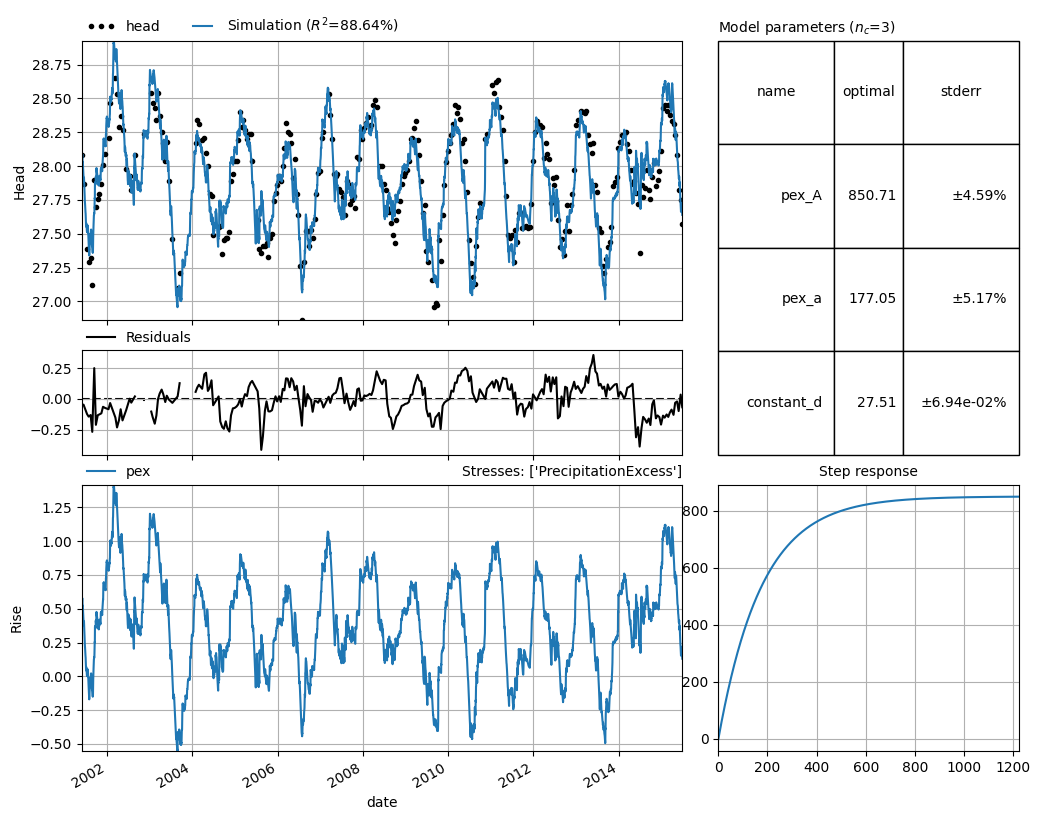

In [7]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Compare Results

### Plot

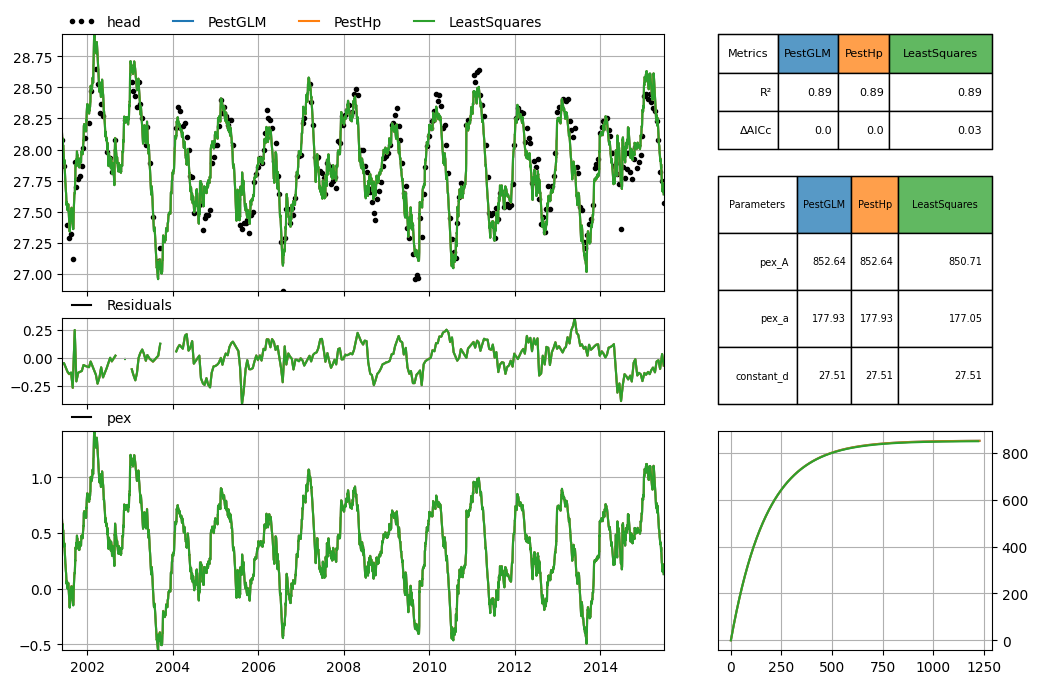

In [8]:
ps.plots.compare([ml, ml_hp, ml_ls], figsize=(12.0, 8.0));

### Fit metrics

In [9]:
pd.concat(
    [ml.stats.summary(), ml_hp.stats.summary(), ml_ls.stats.summary()],
    axis=1,
    keys=[ml.name, ml_hp.name, ml_ls.name],
)

,PestGLM,PestHp,LeastSquares
,Value,Value,Value
Statistic,,,
rmse,0.127435,0.127435,0.127442
sse,4.871941,4.871941,4.872432
mae,0.103328,0.103328,0.103327
nse,0.886460,0.886460,0.886449
evp,88.646036,88.646036,88.644891
rsq,0.886460,0.886460,0.886449
kge,0.916143,0.916143,0.917220
bic,-1218.975692,-1218.975692,-1218.945455


### Parameters (and stderr)

In [10]:
pd.concat(
    [
        ml.parameters.loc[:, ["optimal", "stderr"]],
        ml_hp.parameters.loc[:, ["optimal", "stderr"]],
        ml_ls.parameters.loc[:, ["optimal", "stderr"]],
    ],
    axis=1,
    keys=[ml.name, ml_hp.name, ml_ls.name],
)

PestGLM               PestHp             LeastSquares           
            optimal      stderr  optimal      stderr      optimal     stderr
pex_A       852.644    0.254325  852.644    0.254325   850.706567  39.041745
pex_a       177.927   61.887963  177.927   61.887963   177.047388   9.157405
constant_d   27.508  280.538589   27.508  280.538589    27.508892   0.019103

Standard error for the PestGlm optimization seems a bit too small. The PestHp does not have a standarderror, nor a covariance matrix (`pcov`). PestHp does have parameter sensitivy values but I'm not sure how to interpet those.

### Covariance matrices

In [11]:
pd.concat([ml.solver.pcov, ml_ls.solver.pcov], axis=1, keys=[ml.name, ml_ls.name])

PestGLM                         LeastSquares                       
                pex_A       pex_a  constant_d        pex_A       pex_a constant_d
pex_A        0.064681     15.2408     63.8334  1524.257821  318.811811  -0.687605
pex_a       15.240800   3830.1200  15104.5000   318.811811   83.858060  -0.142915
constant_d  63.833400  15104.5000  78701.9000    -0.687605   -0.142915   0.000365